In [1]:
import os
CODE_DIR = '/home/joshua/Projects/diffae'
os.chdir(f'{CODE_DIR}')

In [2]:
import torch
from torchvision.utils import save_image
from templates import *
from templates_cls import *
from experiment_classifier import ClsModel
import clip
from PIL import Image

import sys
sys.path.append('/home/joshua/Projects/diffae/disentanglement/')
from Losses import id_loss

device ="cuda" if torch.cuda.is_available() else "cpu"

#----------------Load diffusion model----------------------#
Diff_conf = ffhq256_autoenc()
# print(Diff_conf.name)
Diff_model = LitModel(Diff_conf)
Diff_state = torch.load(f'checkpoints/{Diff_conf.name}/last.ckpt', map_location='cpu')
Diff_model.load_state_dict(Diff_state['state_dict'], strict=False)
Diff_model.ema_model.to(device)
Diff_model.ema_model.eval()

#----------------Load FaRL and Arcface model----------------------#
FaRL_model, preprocess = clip.load("ViT-B/16", device="cpu")
FaRL_model = FaRL_model.to(device)
FaRL_state=torch.load("FaRL/checkpoints/FaRL-Base-Patch16-LAIONFace20M-ep64.pth") # you can download from https://github.com/FacePerceiver/FaRL#pre-trained-backbones
FaRL_model.load_state_dict(FaRL_state["state_dict"],strict=False)

BASE_PATH = '/home/joshua/Projects/diffae/disentanglement/'
E_ID_LOSS_PATH = BASE_PATH + 'CNN-project-weights/model_ir_se50.pth'
Arc_model = id_loss.IDLoss(E_ID_LOSS_PATH)
Arc_model = Arc_model.to(device)

Global seed set to 0


Model params: 160.69 M
Loading ResNet ArcFace


In [3]:
test_path = 'imgs_align' # dataset to test the framework
data = ImageDataset(test_path, image_size=256, exts=['jpg', 'JPG', 'png'], do_augment=False, sort_names=True)
print('The number of the data:', len(data))

The number of the data: 12


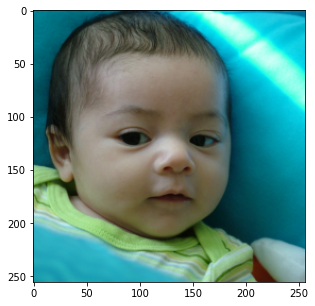

In [6]:
import matplotlib.pyplot as plt

batch = data[0]['img'][None]  # -1 to 1

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ori = (batch + 1) / 2
ax.imshow(ori[0].permute(1, 2, 0).cpu())

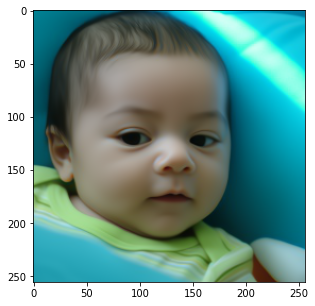

In [25]:
T = 20
in_image = batch.cuda()  # range -1 to 1 
i_image = in_image*0.5+0.5
with torch.no_grad():
    semantic_vec_true = Diff_model.encode(in_image)
    xT_true = Diff_model.encode_stochastic(in_image, semantic_vec_true, T=T)
    ori_img = Diff_model.render(xT_true, semantic_vec_true, T=T)  # ori_img in range 0 to 1
    
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ori_img[0].permute(1, 2, 0).cpu())

In [6]:
ori

tensor([[[[0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0863, 0.0863, 0.0863,  ..., 0.5176, 0.5176, 0.5176],
          [0.0706, 0.0745, 0.0784,  ..., 0.5294, 0.5255, 0.5176],
          [0.0627, 0.0588, 0.0706,  ..., 0.5176, 0.5294, 0.5216]],

         [[0.5137, 0.5020, 0.5098,  ..., 0.4627, 0.4588, 0.4549],
          [0.5098, 0.5059, 0.5137,  ..., 0.4549, 0.4510, 0.4510],
          [0.5098, 0.5020, 0.5059,  ..., 0.4392, 0.4471, 0.4431],
          ...,
          [0.5961, 0.6000, 0.6039,  ..., 0.6157, 0.6078, 0.6078],
          [0.5804, 0.5882, 0.5961,  ..., 0.6157, 0.6118, 0.6118],
          [0.5765, 0.5804, 0.5804,  ..., 0.6118, 0.6196, 0.6157]],

         [[0.5725, 0.5647, 0.5725,  ..., 0.6039, 0.6000, 0.5882],
          [0.5765, 0.5686, 0.5804,  ..., 0.5922, 0.5922, 0.5922],
          [0.5765, 0.5647, 0.5608,  ..., 0

In [23]:
with torch.no_grad():
    in_image_arc = Arc_model.extract_feats(batch.cuda())
    ori_img_arc = Arc_model.extract_feats(ori_img*2-1)
print(cosine_distance(in_image_arc[0], ori_img_arc[0], 0))   

tensor(0.9769, device='cuda:0')


## Start optimization

>`Step 0 to Step 2` test the modules loading.    
>`Step 3` test optimization process in one image

### Step 0. Optimization Initialization

In [4]:
import torchvision.transforms as transforms

def cosine_distance(x_A, x_R, m):
    # Calculate cosine similarity
    cos_sim = torch.dot(x_A, x_R) / (torch.norm(x_A) * torch.norm(x_R))
    # Calculate absolute difference with m
    abs_diff = torch.abs(cos_sim - m)
    return abs_diff

def l1_distance(x_A, x_R):
    # Calculate L1 distance
    diff = x_A - x_R
    dist = torch.norm(diff, p=1)
    return dist

def _convert_image_to_rgb(image):
    return image.convert("RGB")

FaRL_transform0 = transforms.Compose([
    transforms.Resize(size=224, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(size=224),
    transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), 
                         std=(0.26862954, 0.26130258, 0.27577711))
])

`Grab data`

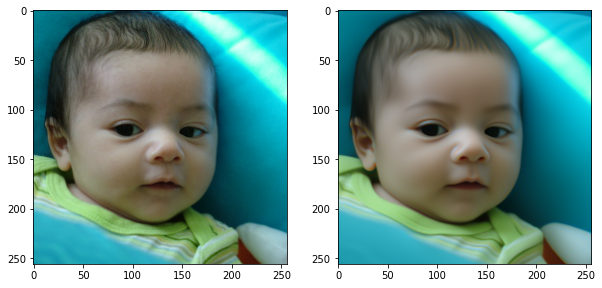

In [7]:
# data to process
batch = data[0]['img'][None]
in_image = batch.cuda()  # (range:[0,1]; size:[1,3,256,256])

# Real Data
Real_image = (in_image + 1) / 2 # (range:[0,1]; size:[1,3,256,256])

# Fake Data
T = 20          # process step number for diffusion model
with torch.no_grad():
    semantic_vec = Diff_model.encode(in_image)
    xT = Diff_model.encode_stochastic(in_image, semantic_vec, T=T)
    Fake_image = Diff_model.render(xT, semantic_vec, T=T)  # (range:[0,1]; size:[1,3,256,256])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(Real_image[0].permute(1, 2, 0).cpu())
ax[1].imshow(Fake_image[0].permute(1, 2, 0).cpu())

### Step 1. FaRL Feature Space (Skip this in Test mode)

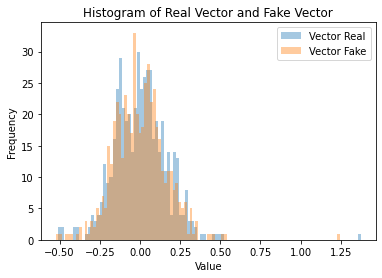

In [17]:
with torch.no_grad():
    FaRL_Real_image = FaRL_model.encode_image(FaRL_transform0(Real_image))
    FaRL_Fake_image = FaRL_model.encode_image(FaRL_transform0(Fake_image))
    
vectorReal_np = FaRL_Real_image[0].cpu().numpy()
vectorFake_np = FaRL_Fake_image[0].cpu().numpy()

# 绘制直方图
plt.hist(vectorReal_np, bins=100, alpha=0.4, label='Vector Real')  # 绘制向量1的直方图
plt.hist(vectorFake_np, bins=100, alpha=0.4, label='Vector Fake')  # 绘制向量2的直方图
plt.legend(loc='upper right')  # 添加图例
plt.xlabel('Value')  # 设置横轴标签
plt.ylabel('Frequency')  # 设置纵轴标签
plt.title('Histogram of Real Vector and Fake Vector')  # 设置标题
plt.show()  # 显示图形

### Step 2. Loss Functions (`Arcface` & `FaRL Features`) [Optional: 这里主要是为了测试loss模组]

`2.1 ArcFace Feature`

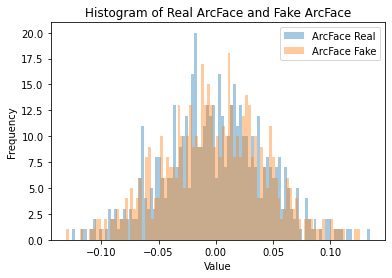

In [16]:
with torch.no_grad():
    Real_ID_Feat = Arc_model.extract_feats(Real_image)
    Fake_ID_Feat = Arc_model.extract_feats(Fake_image)
    
ArcReal_np = Real_ID_Feat[0].cpu().numpy()
ArcFake_np = Fake_ID_Feat[0].cpu().numpy()

# 绘制直方图
plt.hist(ArcReal_np, bins=100, alpha=0.4, label='ArcFace Real')  # 绘制向量1的直方图
plt.hist(ArcFake_np, bins=100, alpha=0.4, label='ArcFace Fake')  # 绘制向量2的直方图
plt.legend(loc='upper right')  # 添加图例
plt.xlabel('Value')  # 设置横轴标签
plt.ylabel('Frequency')  # 设置纵轴标签
plt.title('Histogram of Real ArcFace and Fake ArcFace')  # 设置标题
plt.show()  # 显示图形

`2.1 ArcFace Loss`

In [10]:
# set m in range [0,1], 0 indicates the max distance in ID Space, 1 or 0.9 indicate the min distance in ID Space.
m = 0
ArcFace_Loss = cosine_distance(Real_ID_Feat[0], Fake_ID_Feat[0], m)
print("ArcFace_Loss:", ArcFace_Loss)

ArcFace_Loss: tensor(0.9895, device='cuda:0')


`2.2 FaRL Feature`

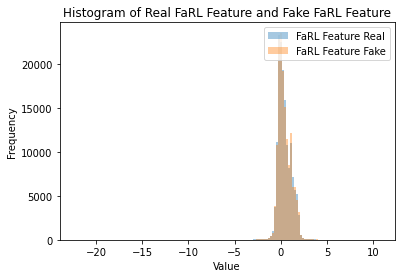

In [15]:
with torch.no_grad():
    FaRL_Patch_Real_image = FaRL_model.visual.conv1(FaRL_transform0(Real_image))  # torch.Size([1, 768, 14, 14])
    FaRL_Patch_Fake_image = FaRL_model.visual.conv1(FaRL_transform0(Fake_image))  # torch.Size([1, 768, 14, 14])
    
FaRL_Patch_Real_image_Flatten = FaRL_Patch_Real_image.view(1, -1)
FaRL_Patch_Fake_image_Flatten = FaRL_Patch_Fake_image.view(1, -1)

FeatureReal_np = FaRL_Patch_Real_image_Flatten[0].cpu().numpy()
FeatureFake_np = FaRL_Patch_Fake_image_Flatten[0].cpu().numpy()

# 绘制直方图
plt.hist(FeatureReal_np, bins=150, alpha=0.4, label='FaRL Feature Real')  # 绘制向量1的直方图
plt.hist(FeatureFake_np, bins=150, alpha=0.4, label='FaRL Feature Fake')  # 绘制向量2的直方图
plt.legend(loc='upper right')  # 添加图例
plt.xlabel('Value')  # 设置横轴标签
plt.ylabel('Frequency')  # 设置纵轴标签
plt.title('Histogram of Real FaRL Feature and Fake FaRL Feature')  # 设置标题
plt.show()  # 显示图形

`2.2 FaRL Loss`

In [18]:
FaRL_Patch_Loss = l1_distance(FaRL_Patch_Real_image_Flatten, FaRL_Patch_Fake_image_Flatten)
print('FaRL_Patch_Loss:', FaRL_Patch_Loss)

FaRL_Patch_Loss: tensor(6573.9814, device='cuda:0')


### Step 3. Calculate Gradient and Backward Propogation

In [ ]:
from torch.autograd import Variable

lr_id = 0.02               # image id learning rate
lr_attribute = 0.008       # image attribute learning rate


# 0.0 Data to process
batch = data[0]['img'][None]
in_image = batch.cuda()  # (range:[0,1]; size:[1,3,256,256])

# Real Data
Real_image = (in_image + 1) / 2 # (range:[0,1]; size:[1,3,256,256])

# 0.1 Fake Data
T = 20          # process step number for diffusion model
with torch.no_grad():
    # no gradient info in this step, cause these tensor do not used to calculate while optimization
    semantic_vec = Diff_model.encode(in_image)
    xT = Diff_model.encode_stochastic(in_image, semantic_vec, T=T)
    Fake_image = Diff_model.render(xT, semantic_vec, T=T)  # (range:[0,1]; size:[1,3,256,256])

# 0.2 Variable used to optimization. `require gradient` set to true
semantic_optimization = Variable(semantic_vec, requires_grad = True)  

# 0.3 Collect generator gradient information here
Fake_image_optimization = Diff_model.render(xT, semantic_optimization, T=T)

# 0.4 set m in range [0,1], 0 indicates the max distance in ID Space, 1 or 0.9 indicate the min distance in ID Space.
m = 0
# Collect arcface gradient information here
with torch.no_grad():
    Real_ID_Feat = Arc_model.extract_feats(Real_image)

Fake_ID_Feat = Arc_model.extract_feats(Fake_image_optimization)
ArcFace_Loss = cosine_distance(Real_ID_Feat[0], Fake_ID_Feat[0], m)

# 0.5 Collect FaRL gradient information here
with torch.no_grad():
    FaRL_Patch_Real_image = FaRL_model.visual.conv1(FaRL_transform0(Real_image))  # torch.Size([1, 768, 14, 14])

FaRL_Patch_Fake_image = FaRL_model.visual.conv1(FaRL_transform0(Fake_image_optimization))  # torch.Size([1, 768, 14, 14])
FaRL_Patch_Real_image_Flatten = FaRL_Patch_Real_image.view(1, -1)
FaRL_Patch_Fake_image_Flatten = FaRL_Patch_Fake_image.view(1, -1)
FaRL_Patch_Loss = l1_distance(FaRL_Patch_Real_image_Flatten, FaRL_Patch_Fake_image_Flatten)

# 0.6 set all nets gradient to zero before backpropagation
Diff_model.zero_grad()
Arc_model.zero_grad()
FaRL_model.zero_grad()

# 0.7 partial derivative at ID
semantic_optimization.retain_grad() # gradient reatin on semantic_optimization
ArcFace_Loss.backward()   # partial derivative at ID

# update semantic_optimization with ID loss
semantic_optimization = semantic_optimization - lr_id*torch.sign(semantic_optimization.grad)

# 0.8 partial derivative at Attributes
Diff_model.zero_grad()
Arc_model.zero_grad()
FaRL_model.zero_grad()

semantic_optimization.retain_grad() # gradient reatin on semantic_optimization
FaRL_Patch_Loss.backward()   # partial derivative at Attributes

# update semantic_optimization with Attribute loss
semantic_optimization = semantic_optimization - lr_id*torch.sign(semantic_optimization.grad)



`plot the result`

In [ ]:
with torch.no_grad():
    Fake_image_optimization = Diff_model.render(xT, semantic_optimization, T=T)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(Real_image[0].permute(1, 2, 0).cpu())
ax[1].imshow(Fake_image_optimization[0].permute(1, 2, 0).cpu())